## Project - Ido and Assaf the gvarim



## imports

In [1]:
import pandas as pd
import numpy as np
import numpy.ma as ma
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from scipy import interp
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

### Load Data

In [2]:
feature_data = pd.read_csv("feature_data.csv")
feature_test_data= pd.read_csv("feature_data_test.csv")
labels = pd.read_csv("label_data.csv")
results = pd.read_csv("example_submission.csv")



## מניפולציות לדאטה

In [3]:
#check how many zeros are in each feature
zero_check =(frames == 0).sum()
zero_check = zero_check.sort_values(ascending = False)
zero_check.plot.bar(color="red")

NameError: name 'frames' is not defined

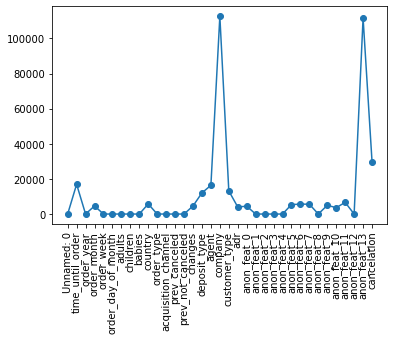

In [4]:
#here we check how many values are Nan. It might help us in the feature selection,we would like to have as much information as possible.
frames = pd.concat([feature_data,feature_test_data]) #concating two df's
na_check =frames.isna().sum()
plt.xticks(rotation=90)
plt.plot(na_check,marker= 'o')



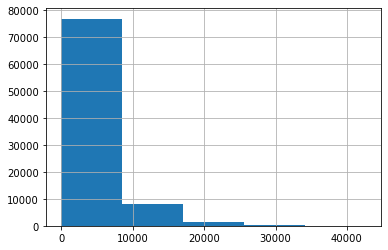

In [5]:
hist = feature_data["adr"].hist(bins=5)
#y is the value of adr.
#x is how many customers, we can see that most of the customers has a low adr value.

In [6]:
#giving a name to the first column

feature_test_data = feature_test_data.rename(columns={feature_test_data.columns[0]: 'id'}) 
feature_data = feature_data.rename(columns={feature_data.columns[0]: 'id'})

#months
feature_test_data["order_month"].replace({"January": 1, "February": 2, "March": 3, "April":4, "May" : 5, "June": 6, "July" : 7, "August" : 8, "September" : 9, "October" : 10, "November" : 11, "December" : 12}, inplace=True)
feature_data["order_month"].replace({"January": 1, "February": 2, "March": 3, "April":4, "May" : 5, "June": 6, "July" : 7, "August" : 8, "September" : 9, "October" : 10, "November" : 11, "December" : 12}, inplace=True)

#order_week-Cutting the "week_"
feature_test_data.order_week = feature_test_data.order_week.str.slice(start = 5)
feature_data.order_week = feature_data.order_week.str.slice(start = 5)

#deal with the empty places in the "order_month" column. There are 4.2 weeks in a month plus minus 2 days.
feature_test_data.order_month = np.where(feature_test_data.order_month.isnull(), ((feature_test_data['order_week'].astype('double'))/4.2).astype('int'), feature_test_data.order_month)
feature_data.order_month = np.where(feature_data.order_month.isnull(), ((feature_data['order_week'].astype('double'))/4.2).astype('int'), feature_data.order_month)


#when there is no agent involved in the order, we can treat it like "agent 0"
feature_test_data['agent'].fillna(0)
feature_data['agent'].fillna(0)
#same thing with company 
feature_test_data['company'].fillna(0)
feature_data['company'].fillna(0)

#We noticed that those two columns are almost the same except when the order_type is group.
#So the idea is to gather the information in one column instead of two.

for a, b in zip(feature_test_data.order_type,feature_test_data.acquisition_channel):
    if b == "Corporate":
        a = "Corporate"

for c, d in zip(feature_data.order_type,feature_data.acquisition_channel):
    if c == "Corporate":
        d = "Corporate"
#now we can cut the acquisition_channel coloumn because we already have all of its new information:
del feature_test_data["acquisition_channel"]
del feature_data["acquisition_channel"]



#If we have less than 1% appearance of a country it means that we probably don't have enough samples to predict cancel given this information.
#Here we change the countries that don't appear enough (less than 1%) into zeros.


feature_data.loc[feature_data.groupby('country')['id']
         .transform('size')
         .div(len(feature_data))
         .lt(0.01), 
       'country'] = 0

feature_test_data.loc[feature_test_data.groupby('country')['id']
         .transform('size')
         .div(len(feature_data))
         .lt(0.01), 
       'country'] = 0

###Here we check which countries appear the most se we can rate those by decending order 
count_countries2 = feature_test_data.groupby('country')['id'].nunique()
count_countries = feature_data.groupby('country')['id'].nunique()
#based on the count we replace the values by the number of samples, when PRT is the highest.
feature_data['country'] = feature_data['country'].replace({'PRT': 1, 'GBR': 2, 'FRA': 3, 'ESP' : 4, 'DEU': 5, 'ITA': 6, 'IRL': 7, 'BEL': 8, 'BRA':9, 'NLD':10, 'USA': 11,'CHE':12,'CN':13,'AUT':14})
feature_test_data['country'] = feature_test_data['country'].replace({'PRT': 1, 'GBR': 2, 'FRA': 3, 'ESP' : 4, 'DEU': 5, 'ITA': 6, 'IRL': 7, 'BEL': 8, 'BRA':9, 'NLD':10, 'USA': 11,'CHE':12,'CN':13,'AUT':14})

#if it's a uncommon country/no info we will call it "country 0"
feature_test_data['country'] = feature_test_data['country'].fillna(0)
feature_data['country'] = feature_data['country'].fillna(0)


feature_data['cancelation'] = labels['cancelation']



## Making a new Feature- Season

In [7]:
#If the month is April-September we will get the value 1 (this will mean summer).
#Else its winter with the value 0.
feature_data['season'] = [1 if (x > 3 and x < 10) else 0 for x in feature_data["order_month"]]
feature_test_data['season'] = [1 if x > 3 and x < 10 else 0 for x in feature_test_data["order_month"]]



### ניסיונות לבחירת פיצ'רים בצורה אופטימלית

המימדיות של הבעיה אכן גדולה מדי, יש למעלה מ30 משתנים מסבירים, שמראים לנו (בשאיפה) אם יקרה ביטול להזמנה או לא. היות ויש כל כך הרבה פיצ'רים לעבור עליהם זה יקח למחשב הרבה זמן יקר, שאפשר לחסוך על ידי זיהוי הפיצ'רים המשמעותיים יותר ולאמן את המחשב רק עליהם. תהליך הזיהוי שלנו כלל הרבה ניסוי וטעייה, הרעיון הכללי הוא בדיקת ההסתברות שיקרה ביטול בהינתן ופיצ'ר מסויים שווה לערך מסויים. אנחנו נצפה שככל שההסתברות שונה יותר מ38% (שזו הסתברות הביטול שמצאנו פחות או יותר), כך הפיצ'ר הזה כנראה יותר קריטי. אם קיבלנו שההסתברות היא בפחות מאחוז הבדל, כנראה שהפיצ'ר לא יעזור לנו לחזות אם קרה ביטול או לא. 
באופן כללי, הפיצ'רים שנפטרנו מהם זה פיצ'רים כמעט ריקים, פיצ'רים שברובם אפסים, פיצ'רים שלא מלמדים אותנו שום דבר חדש (הסתברות הביטול בלתי תלויה בערך הפיצ'ר) ופיצ'רים שניתן להסיק אותם על ידי עמודות אחרות. 
במלבן הבא ניסינו להבין בעצם אילו פיצ'רים הכי קריטיים והכי משפיעים על ביטול לפי העקרונות שהצגתי למעלה

In [8]:

p_cancel = feature_data.groupby('cancelation').count()['id'] / len(feature_data)
print("probability of not cancelation is: ", p_cancel[0])
#p_cancel[0] is False and p_cancel[1] means they cancel


max = 0
qu = []

for i in range(0,15):
    f1 = feature_data[feature_data["country"] == i ].groupby('cancelation').count()['id'][0] #not cancel
    t1 = feature_data[feature_data["country"] == i ] .groupby('cancelation').count()['id'][1] #cancel
    qu.append(f1 / (f1 + t1)) #probability of canceling is compute by taking the times were there was false in the cancelation column
    #and diving it by popluation.
print("cancel by countries: ",qu)

#Here we see that there is a correlation between the different common countries and the cancelation,
#but there is no linear correlation between the numbers of the countries and cancelation. so what we did is to rearrange the numbers such as the countries
#will be in order. Usually in spots like this we should use one hot encoding, but in this case it will create way too many new columns. 

feature_data['country'] = feature_data['country'].replace({0:11, 1:14, 2:5, 3:2, 4:9, 5:0, 6:12, 7:10, 8:6, 9:13, 10:3, 11:8,12:7,13:4 , 14: 1})
feature_test_data['country'] = feature_test_data['country'].replace({0:11, 1:14, 2:5, 3:2, 4:9, 5:0, 6:12, 7:10, 8:6, 9:13, 10:3, 11:8,12:7,13:4 , 14: 1})


#Here we check the probability of cancelation when the value of anon_feat_6 is bigger than 0 (in the next box we will see it happens less than 7.5% of the time)
#we also checked what happenes when the feature = 0. in this case the probability was 63% (a number really close to the original p_cancel[1])
#Even though we get here 35% which is far from 63%, most of the time the feature doesn't help, and even when it help it doesn't give us an unambiguous prediction.
#This is why we this features wasn't included in the feature selection.
f6 = feature_data[feature_data['anon_feat_6'] > 0].groupby('cancelation').count()['id'][0]
t6 = feature_data[feature_data['anon_feat_6'] > 0 ] .groupby('cancelation').count()['id'][1]

#print("anon_feat_6: ", f6 / (f6 + t6)) #35%

f12= feature_data[feature_data["anon_feat_12"] == True].groupby('cancelation').count()['id'][0]
t12 = feature_data[feature_data["anon_feat_12"] == True ] .groupby('cancelation').count()['id'][1]

#print("anon_feat_12: ", f12 / (f12 + t12)) #p = 62%, which means this feature can be unreliable, so we removed it.
#even when we checked anon_feat_12 == false we saw we still get 62%, that means that in both possible values of anon_feat_12, there is no connection.

#Checking all possible values for anon_feat_8
print("anon_feat_8 probs: ")
a= 0
for a in range(0,5):
    f8= feature_data[feature_data['anon_feat_8'] == a ].groupby('cancelation').count()['id'][0]
    t8 = feature_data[feature_data['anon_feat_8'] == a ] .groupby('cancelation').count()['id'][1]
    print(a, f8/(f8 + t8)) #here we can see the numbers are in acending order, which means there is a correlation. this feature will go into our feature selection.

#With this feature we actually had an error running t7 with some values, the reason for that was that for certain values, no one cancels the flight at all.
#We believe this feature can be a nice indicator for our model.
f7= feature_data[feature_data['anon_feat_7'] == 0 ].groupby('cancelation').count()['id'][0]
t7 = feature_data[feature_data['anon_feat_7'] == 0 ] .groupby('cancelation').count()['id'][1]
#print("feat_7: ", f7/(f7 + t7) )

f4= feature_data[feature_data['anon_feat_4'] == 7 ].groupby('cancelation').count()['id'][0]
t4 = feature_data[feature_data['anon_feat_4'] == 7 ] .groupby('cancelation').count()['id'][1]


score = []
customer = []
for j in range(0,9):
    f5= feature_data[feature_data['anon_feat_5'] == j ].groupby('cancelation').count()['id'][0]
    t5 = feature_data[feature_data['anon_feat_5'] == j ] .groupby('cancelation').count()['id'][1]
    score.append(f5 / (f5 + t5))
print("anon_feat_5 probs: ")
print(score) #We took anon_feat_5 because we saw that all the values there are different from 62% by more than 3%, which means that maybe this feature can help.

customers = ["Contract","Transient","Transient-Party","Group" ]
for h in customers:
    fc= feature_data[feature_data['customer_type'] == h ].groupby('cancelation').count()['id'][0]
    tc = feature_data[feature_data['customer_type'] == h ] .groupby('cancelation').count()['id'][1]
    customer.append(fc / (fc + tc))
#print("Customer prob: ",customer) #The reason we took this feature out is that three of the possibilities are close to 62%. The one that isn't is "Group",
#where it is less than 5% of the data in total.

fs0 = feature_data[feature_data['season'] == 0 ].groupby('cancelation').count()['id'][0]
ts0 = feature_data[feature_data['season'] == 0 ].groupby('cancelation').count()['id'][1]

fs1 = feature_data[feature_data['season'] == 1].groupby('cancelation').count()['id'][0]
ts1 = feature_data[feature_data['season'] == 1 ].groupby('cancelation').count()['id'][1]
#print("p not cancel in summer: ",fs0/(fs0+ts0))
#print("p not cancel in winter: ",fs1/(fs1+ts1)) #We can see that the new feature doesn't help us enough.

probability of not cancelation is:  0.6292689464162069
cancel by countries:  [0.6796001888871399, 0.4327088840363177, 0.7956431535269709, 0.8168635875402793, 0.7504051863857374, 0.8274621212121213, 0.6443104747550866, 0.7533167495854063, 0.7991827203736136, 0.6236760124610592, 0.809775429326288, 0.7557452396585687, 0.7577019150707743, 0.7970085470085471, 0.8166666666666667]
anon_feat_8 probs: 
0 0.5233031974375012
1 0.7775046344805352
2 0.7793398533007335
3 0.8221746116764863
4 0.90625
anon_feat_5 probs: 
[0.5541993661334138, 0.7674870466321243, 0.8123883263847528, 0.7468069944636299, 0.7496382054992764, 0.756463094792057, 0.6909385113268608, 0.6569200779727096, 0.9884615384615385]


במלבן הבא בדקנו כל מיני קורלציות לפי מקדם פירסון, רצינו לקבל תמונה כללית שתעזור לנו לאתר פיצ'רים טובים בצורה ויזואלית.
מה שנרצה לחפש זה צבע כמה שיותר כהה של אדום בשורה התחתונה- שורת 
cancelation.

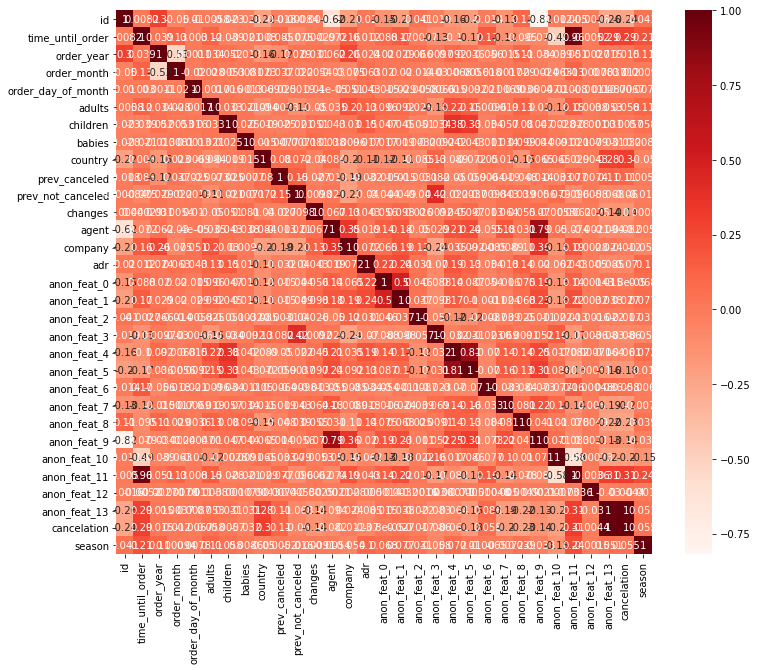

id                    0.242871
time_until_order      0.294502
order_year            0.014949
order_month           0.012078
order_day_of_month    0.006737
adults                0.058103
children              0.005691
babies                0.032331
country               0.304186
prev_canceled         0.109633
prev_not_canceled     0.060068
changes               0.144559
agent                 0.081911
company               0.012482
adr                   0.070436
anon_feat_0           0.000038
anon_feat_1           0.026997
anon_feat_2           0.016972
anon_feat_3           0.085612
anon_feat_4           0.060772
anon_feat_5           0.176803
anon_feat_6           0.058219
anon_feat_7           0.197533
anon_feat_8           0.233985
anon_feat_9           0.136527
anon_feat_10          0.204077
anon_feat_11          0.313919
anon_feat_12          0.004417
anon_feat_13          1.000000
cancelation           1.000000
season                0.054713
Name: cancelation, dtype: float64


In [9]:
plt.figure(figsize=(12,10))
cor = feature_data.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show() 
cor_target = abs(cor["cancelation"])
#Checking highly correlated features in Pearson correlation
print(cor_target)

Pie of:  order_week


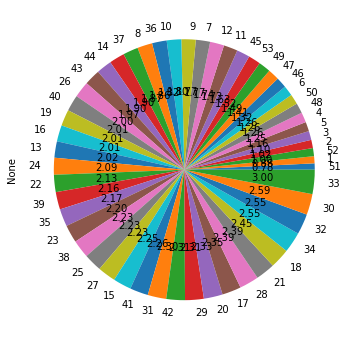

Pie of:  order_type


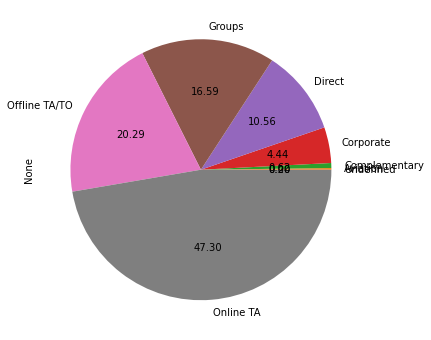

Pie of:  deposit_type


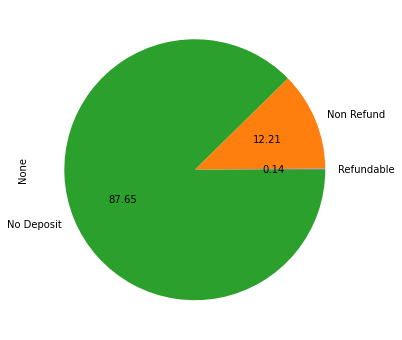

Pie of:  customer_type


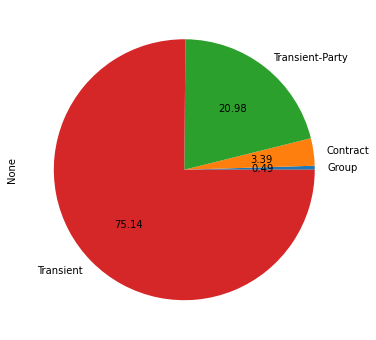

Pie of:  cancelation


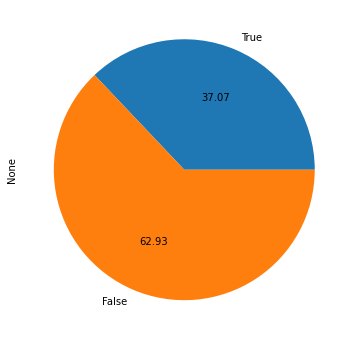

In [10]:
#observe distribution for every categorial feature
frames = pd.concat([feature_data,feature_test_data])
columns = frames.dtypes
columns = columns[columns==('object')]
columns = columns.reset_index()
columns = columns['index']
for col in columns:
    print("Pie of: ",col)
    frames.groupby(col).size().sort_values(ascending=True).plot(kind='pie', autopct='%.2f',figsize=(6,6))
    plt.show()


<AxesSubplot:>

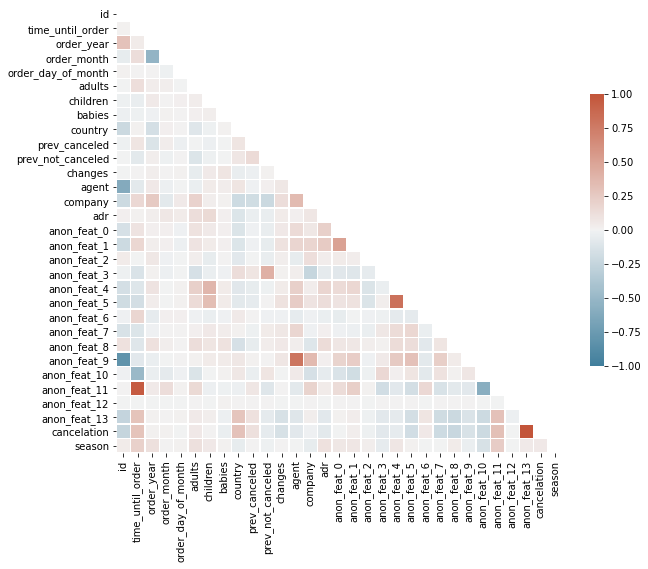

In [11]:
#Here we check another correlation between the columns
correlation_matrix = feature_data.corr()
mask = np.triu(np.ones_like(correlation_matrix,dtype=bool))
f,ax = plt.subplots(figsize=(10,10))
cmap = sns.diverging_palette(230,20,as_cmap=True)
sns.heatmap(correlation_matrix,mask=mask,cmap=cmap,vmin=-1,vmax=1,center=0,
                square=True,linewidths=.5,cbar_kws={"shrink": .5})


## Finding the outliers and deal with them

שיטת העבודה שלנו פה הייתה לספור את הערכים האפשריים לכל פיצ'ר בטבלה ולראות האם אנחנו מזהים חריגות בדאטה- (ערך גבוה משמעותית מהאחרים או ערך שמופיע רק פעם- פעמיים וכדומה)

In [12]:

#in the following lines we delete data that we don't have enough info on, so we check the frequency of values and remove everytime the sample is too small.
count_dep = feature_data.groupby('deposit_type').count()

count_babies = feature_data.groupby('babies').count()

count_children = feature_data.groupby('children').count()

count_adr = feature_data.groupby('adr').count()
count_anon0 = feature_data.groupby(['anon_feat_0']).count()
count_anon1 = feature_data.groupby('anon_feat_1').count()
count_anon2 = feature_data.groupby('anon_feat_2').count()
count_anon3 = feature_data.groupby('anon_feat_3').count()
count_anon4 = feature_data.groupby('anon_feat_4').count()
count_anon5 = feature_data.groupby('anon_feat_5').count()
count_anon6 = feature_data.groupby('anon_feat_6').count()
count_anon7 = feature_data.groupby('anon_feat_7').count()
count_anon8 = feature_data.groupby('anon_feat_8').count()
count_anon9 = feature_data.groupby('anon_feat_9').count()
count_anon10 = feature_data.groupby('anon_feat_10').count()
count_anon11 = feature_data.groupby('anon_feat_11').count()
count_anon12 = feature_data.groupby('anon_feat_12').count()
count_customer_type = feature_data.groupby('customer_type').count()
count_order_type = feature_data.groupby('order_type').count()
count_changes = feature_data.groupby('changes').count()
count_prev_canceled = feature_data.groupby('prev_canceled').count()

print(count_prev_canceled)

feature_data["anon_feat_5"] = feature_data["anon_feat_5"].fillna(feature_data["anon_feat_5"].mean())
feature_data["anon_feat_4"] = feature_data["anon_feat_4"].fillna(feature_data["anon_feat_4"].mean())

#Here we throw away values that didn't appear that often
feature_data = feature_data[feature_data.order_type != "Aviation"]
feature_data = feature_data[feature_data.order_type != "Undefined"]
feature_data = feature_data[feature_data.order_type != "Complementary"]
feature_data = feature_data[feature_data.deposit_type != 'Group']
feature_data = feature_data[feature_data.deposit_type != 'Refundable']

feature_data["anon_feat_11"] = feature_data["anon_feat_11"].fillna(feature_data["anon_feat_11"].mean())
feature_data['changes'] = feature_data['changes'].fillna(0)
feature_data["anon_feat_1"] = feature_data["anon_feat_1"].fillna(feature_data["anon_feat_1"].mean())
feature_data["anon_feat_7"] = feature_data["anon_feat_7"].fillna(feature_data["anon_feat_7"].mean())
feature_data["anon_feat_2"] = feature_data["anon_feat_2"].fillna(feature_data["anon_feat_2"].mean())
feature_data["anon_feat_10"] = feature_data["anon_feat_10"].fillna(feature_data["anon_feat_10"].mean())
feature_data["adr"] = feature_data["adr"].fillna(feature_data["adr"].mean()) 
feature_data["anon_feat_0"] = feature_data["anon_feat_0"].fillna(feature_data["anon_feat_0"].mean())
feature_data["time_until_order"] = feature_data["time_until_order"].fillna(feature_data["time_until_order"].mean())

                                                                 
#one hot encoding to deposit_type column
feature_data = pd.get_dummies(feature_data, columns=['order_type','deposit_type'])
feature_test_data = pd.get_dummies(feature_test_data, columns=['order_type','deposit_type'])



                  id  time_until_order  order_year  order_month  order_week  \
prev_canceled                                                                 
0              84677             72711       84677        84677       84677   
1               4535              3869        4535         4535        4535   
2                 86                69          86           86          86   
3                 55                45          55           55          55   
4                 27                26          27           27          27   
5                 13                12          13           13          13   
6                 15                11          15           15          15   
11                25                20          25           25          25   
13                 9                 8           9            9           9   
14                 9                 8           9            9           9   
19                13                11          13  

## Deal with missing values in feature_test_data and normalize

כמובן שאנחנו לא יכולים למחוק שורות מקובץ המבחן, לכן בחרנו למלא את השורות בממוצע המשוקלל של הערכים מהדאטה-סט המקורי. הבחירה בממוצע נבעה ממספר סיבות:
א. הממוצע הוא המספר שהכי פחות "רחוק" מכל המספרים, ואנחנו מאמינים שזה מקטין את הטעות כתוצאה מהמידע החסר.
ב. ניסינו למלא בעוד כל מיני דרכים, כמו בחציון או בערך השכיח, אבל עם הממוצע הגענו לתוצאות יחסית טובות.

In [13]:
#Filling missing values
feature_test_data["time_until_order"] = feature_test_data["time_until_order"].fillna(feature_data["time_until_order"].mean())
feature_test_data["anon_feat_0"] = feature_test_data["anon_feat_0"].fillna(feature_data["anon_feat_0"].mean())
feature_test_data["anon_feat_1"] = feature_test_data["anon_feat_1"].fillna(feature_data["anon_feat_1"].mean())
feature_test_data["anon_feat_2"] = feature_test_data["anon_feat_2"].fillna(feature_data["anon_feat_2"].mean())
feature_test_data["anon_feat_4"] = feature_test_data["anon_feat_4"].fillna(feature_data["anon_feat_4"].mean())
feature_test_data["anon_feat_5"] = feature_test_data["anon_feat_5"].fillna(feature_data["anon_feat_5"].mean())
feature_test_data["anon_feat_11"] = feature_test_data["anon_feat_11"].fillna(feature_data["anon_feat_11"].mean())
feature_test_data["anon_feat_7"] = feature_test_data["anon_feat_7"].fillna(feature_data["anon_feat_7"].mean())
feature_test_data["anon_feat_10"] = feature_test_data["anon_feat_10"].fillna(feature_data["anon_feat_10"].mean())

#We will fill predictions in this column later
feature_test_data["cancelation"] = 0 


## Feature Selection:

In [14]:

model = feature_data.filter(['country',"time_until_order",'prev_canceled','order_type_Corporate','order_type_Direct','order_type_Groups','order_type_Offline TA/TO','order_type_Online TA','deposit_type_No Deposit','deposit_type_Non Refund','anon_feat_0','anon_feat_1','anon_feat_2','anon_feat_4','anon_feat_5','anon_feat_7','anon_feat_8','anon_feat_10','anon_feat_11','cancelation'], axis=1)
model_test = feature_test_data.filter(['country',"time_until_order",'prev_canceled','order_type_Corporate','order_type_Direct','order_type_Groups','order_type_Offline TA/TO','order_type_Online TA','deposit_type_No Deposit','deposit_type_Non Refund','anon_feat_0','anon_feat_1','anon_feat_2','anon_feat_4','anon_feat_5','anon_feat_7','anon_feat_8','anon_feat_10','anon_feat_11','cancelation'], axis=1)




## K-fold function

In [15]:
def KfoldPlot(X, y, clf, k):
    
    
    clfname = str(clf)[:str(clf).find("(")]
    
    plt.figure()
    
    kf = KFold(n_splits=k, shuffle=False)

    #Since we need to interpolate data, we set an mean tpr and fpr for later porpuses.
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)

    i=1
    for train_index, validation_index in kf.split(X):
        
        print("folding No. ", i)
        
        #Splitting into train and validation, based on the current fold.
        X_train, X_validation = X[train_index], X[validation_index]
        y_train, y_validation = y[train_index], y[validation_index]


        clf.fit(X_train, y_train)
        
        #The prediction we want to test against are the probability of 1 of the X_test
        prob_prediction = clf.predict_proba(X_validation)[:, 1]
        
        #Right now we can set our ROC curve on the specific fold.
        fpr, tpr, thresholds = roc_curve(y_validation, prob_prediction)
        
        #We interpolate the mean_tpr so all of the classifiers will be working under the same thersholds.
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        
        #Plotting the fold 
        plt.plot(fpr, tpr, color='#D3D3D3')
        i+=1
    
    plt.plot([0], [0], color='#D3D3D3', linestyle='-', label='K-folds')    
    
    
    #Right now the mean_tpr is a sum (we added each iteration, so we finally divide by the number of folds)
    mean_tpr /= k
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    
    plt.plot(mean_fpr, mean_tpr, color='red', linestyle='-', label='Mean ROC (area = %0.3f)' % mean_auc)

    #Setting some boundaries .
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for ' + clfname)
    plt.legend(loc="lower right")
    plt.show()

## Preparing to train and test

In [16]:
X, y = model.values[:,:-1], model.values[:, -1]
y=y.astype('int')


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
scaler =StandardScaler()
train_scaled = scaler.fit_transform(X_train)
valid_scaled = scaler.fit_transform(X_test)


## הרצת מודלים- KNN

The score is:  0.8692355395196752
AUC:  0.7893299637445061
folding No.  1
folding No.  2
folding No.  3
folding No.  4
folding No.  5
folding No.  6
folding No.  7
folding No.  8
folding No.  9
folding No.  10


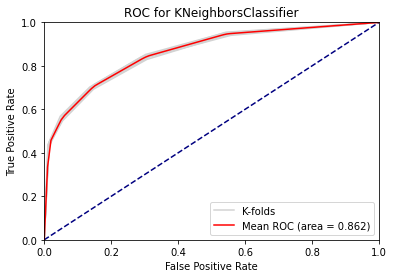

In [17]:

classifier = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto', 
                                  leaf_size=30, p=2, metric='manhattan', metric_params=None, n_jobs=None)
classifier.fit(train_scaled, y_train)
y_pred_labels = classifier.predict_proba(valid_scaled)
y_pred = classifier.predict(valid_scaled)


print("The score is: ",classifier.score(train_scaled,y_train))
fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred)
print("AUC: " ,metrics.auc(fpr,tpr))

KfoldPlot(X, y, classifier, 10)

The auc is 78.933%


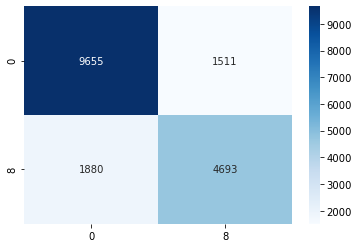

<Figure size 1440x1440 with 0 Axes>

In [18]:
#Confusion Matrix for K-NN:
cm = confusion_matrix(y_test ,y_pred)
print("The auc is {}%".format(round(metrics.auc(fpr,tpr)*100,4)))
sns.heatmap(cm,annot=True,fmt='g',cmap='Blues', xticklabels = [0,8], yticklabels = [0,8])
plt.show()
fig= plt.figure(figsize=(20,20))


המספר השמאלי למעלה אומר שניחשנו שיקרה ביטול ובאמת כך קרה.
המספר הימני למעלה אומר כמה פעמים המודל טען שלא יקרה ביטול אבל בעצם כן קרה אחד.
המספר השמאלי למטה אומר הפוך- המספר מייצג כמה פעמים המודל חשב שיקרה ביטול אבל לא קרה.
הימני למטה זה כמה פעמים המודל חישב שלא יקרה ביטול ובאמת הטיסה לא התבטלה.


In [19]:
#Cs = [10**p for p in range(-10,0)]
#grid = {"C":Cs, 
#        "penalty":["l2","l1"],
#        "solver":["liblinear","lbfgs"],
#        "max_iter":[100,200]}
#clf = LogisticRegression()
#clf_grid_cv= GridSearchCV(clf,grid,cv=10,scoring="roc_auc")
#clf_grid_cv.fit(X_train,y_train)
#print(clf_grid_cv.best_params_)
        

[3.08597061e-04 5.45385271e-12 3.40387174e-02 ... 4.60432499e-02
 1.66069610e-01 2.58527679e-01]
The score is:  0.7543268688690946
AUC:  0.680742392735069
folding No.  1
folding No.  2
folding No.  3
folding No.  4
folding No.  5
folding No.  6
folding No.  7
folding No.  8
folding No.  9
folding No.  10


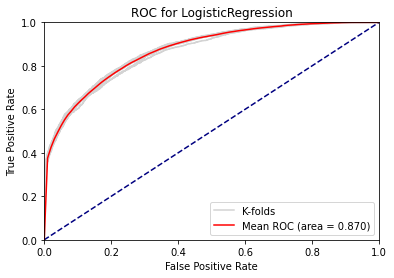

In [20]:

log_clf = LogisticRegression(C= 0.1, max_iter= 100, penalty='l1', solver= 'liblinear')
log_clf.fit(X_train, y_train)
y_pred_labels = log_clf.predict_proba(valid_scaled)[:,1]
y_pred = log_clf.predict(valid_scaled)

print(y_pred_labels)
print("The score is: ",log_clf.score(train_scaled,y_train))
fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred)
print("AUC: " ,metrics.auc(fpr,tpr))
KfoldPlot(X, y, log_clf, 10)

## Random Forest

In [133]:
#partial GridSearch
#n_estimators = [int(x) for x in np.linspace(start = 10, stop = 200, num = 10)]

#param_grid = {'n_estimators': n_estimators,
#             'min_samples_leaf': [1,2,3,4],
#             'min_samples_split': [2,5],
#             }

#clf = RandomForestClassifier(random_state=42)
#rf_grid = GridSearchCV(estimator = clf , param_grid = param_grid)

#rf_grid.fit(X_train, y_train)
#print(rf_grid.best_params_)



The score is:  0.8297299582816552
AUC:  0.7961861875634229
folding No.  1
folding No.  2
folding No.  3
folding No.  4
folding No.  5
folding No.  6
folding No.  7
folding No.  8
folding No.  9
folding No.  10


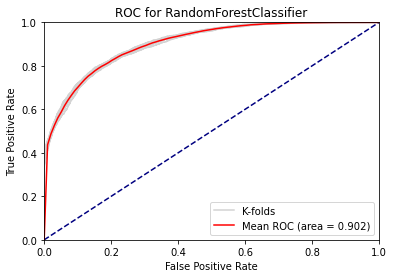

In [21]:
#Those are the best parameters
clf = RandomForestClassifier(n_estimators=200, criterion='gini', max_depth=10,min_samples_split=2, min_samples_leaf=2,
                             min_weight_fraction_leaf=0.0,max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0,            min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None,
                             random_state=42, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0, max_samples=None)

clf.fit(train_scaled, y_train)

y_pred = clf.predict(valid_scaled)
y_pred_labels =  clf.predict_proba(valid_scaled)[:,1]
print("The score is: ",clf.score(train_scaled,y_train))
fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred)
print("AUC: " ,metrics.auc(fpr,tpr))


KfoldPlot(X, y, clf, 10)

### Decision tree

In [135]:
#parameters={"splitter":["best"],
#            "max_depth" : [1,3,5,7,9,11,12],
#           "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10]}

#dtclf = DecisionTreeClassifier(random_state=42)
#tuning_model=GridSearchCV(estimator = dtclf,param_grid=parameters,scoring='neg_mean_squared_error')

#tuning_model.fit(X_train, y_train)
#print(tuning_model.best_params_) 


[0 0 0 ... 1 0 0]
Decision tree accuracy(in %): 81.91555330063701
AUC:  0.7948961250545991
folding No.  1
folding No.  2
folding No.  3
folding No.  4
folding No.  5
folding No.  6
folding No.  7
folding No.  8
folding No.  9
folding No.  10


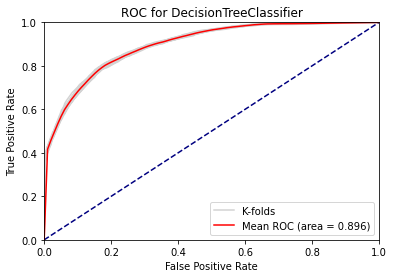

In [22]:
dtclf = DecisionTreeClassifier( criterion='gini', splitter='best', max_depth=12, min_samples_split=2, min_samples_leaf=9,
                               min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None,
                               min_impurity_decrease=0.0, min_impurity_split=None, class_weight=None, ccp_alpha=0.0)
dtclf = dtclf.fit(train_scaled,y_train)

y_pred = dtclf.predict(valid_scaled)
y_pred_labels = dtclf.predict_proba(valid_scaled)[:,1]
print(y_pred)
print("Decision tree accuracy(in %):", metrics.accuracy_score(y_test, y_pred)*100)
fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred)
print("AUC: " ,metrics.auc(fpr,tpr))
KfoldPlot(X, y, dtclf, 10)


To avoid overfitting we tried to be careful with the hyper- parameters tuning. For example, in random forest, if the max_depth is higher we will get a better score. The price will be overfitting, this is why we tried to find a sweetspot that will increase our score but will lower the chance of overfitting.


In [23]:
X_test, y_test = model_test.values[:,:-1], model_test.values[:, -1]

X, y = model.values[:,:-1], model.values[:, -1]
y=y.astype('int')


clf = RandomForestClassifier(n_estimators=136, criterion='gini', max_depth=10,min_samples_split=2, min_samples_leaf=4,
                             min_weight_fraction_leaf=0.0,max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0,            min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None,
                             random_state=42, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0, max_samples=None)

clf.fit(X, y)
y_pred_labels = clf.predict_proba(X_test)
results["cancel_proba"] = y_pred_labels[:,1]
print(results)

       Unnamed: 0  cancel_proba
0           22167      0.125877
1           11664      0.990875
2           43471      0.465370
3            7697      0.640903
4          106026      0.025577
...           ...           ...
29843       85122      0.108248
29844       80166      0.944346
29845      107905      0.359885
29846       78430      0.145844
29847       77502      0.474359

[29848 rows x 2 columns]


In [24]:
results.to_csv("csv.number_group_18")